In [114]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv0 = nn.Conv2d(1, 256, kernel_size=3, stride=1, padding=1)
        self.conv1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AvgPool2d(2)
        self.relu = nn.ReLU()
        self.fc0 = nn.Linear(256, 256)
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv0(x)))
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc0(x))
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Model().to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-3)

model1 = Model().to(device)
optimizer1 = optim.Adam(model1.parameters(),lr=1e-3)

model2 = Model().to(device)
optimizer2 = optim.Adam(model2.parameters(),lr=1e-3)

model3 = Model().to(device)
optimizer3 = optim.Adam(model3.parameters(),lr=1e-3)

criter = nn.MSELoss()

In [115]:
def pi(board, model = model, epsilon = 0.01):
  a = -1
  max = -10000
  batch = []
  where = []
  c = 0
  for i in range(11):
    for j in range(11):
      if board[i,j] == 0:
        batch += [board.copy().reshape(1,11,11)]
        batch[-1][0,i,j] = 1
        where += [[i,j]]
        c += 1

  if c == 0:
    return a

  batch = torch.tensor(np.array(batch), dtype=torch.float32).to(device)
  output = model(batch) + torch.normal(0, 0.1, size=(len(batch),1)).to(device)
  output = output.reshape(-1)
  a = where[torch.argmax(output.reshape(-1))]

  if np.random.random() < epsilon:
    while True:
      a = [np.random.randint(0,11),np.random.randint(0,11)]
      if board[a[0]][a[1]] == 0:
        break
  return a

In [116]:
def win_check(board, last = [0,0]):
  new_board = np.array([0]*19*19).reshape(19,19)
  new_board[4:15,4:15] = board
  for i in range(5):
    if np.sum(new_board[4+last[0], 4+last[1]-i:4+last[1]+5-i]) == 5:
      return True
    elif np.sum(new_board[4+last[0]-i:4+last[0]+5-i, 4+last[1]]) == 5:
      return True

  now = last.copy()
  sum = 0
  for i in range(9):
    if new_board[tuple(now)] == 1:
      sum += 1
    else:
      sum = 0
    if sum == 5:
      return True
    now[0] += 1
    now[1] += 1

  now = last.copy()
  now[0] += 8
  sum = 0
  for i in range(9):
    if new_board[tuple(now)] == 1:
      sum += 1
    else:
      sum = 0
    if sum == 5:
      return True
    now[0] -= 1
    now[1] += 1

  return False

In [117]:
def train(batch_input, batch_target, model = model, optimizer = optimizer):
  batch_output = model(torch.tensor(batch_input, dtype=torch.float32).to(device))
  batch_target = torch.tensor(batch_target, dtype=torch.float32).to(device)
  loss = criter(batch_output, batch_target)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

In [118]:
def show_board(board):
  new_board = board.copy()*-1
  for i in range(11):
    for j in range(11):
      if new_board[i,j] == 0:
        if (i+j) % 2 == 0:
          new_board[i,j] = 0.05
        else:
          new_board[i,j] = -0.05
  plt.imshow(new_board, vmin=-1, vmax=1, cmap='gray')
  plt.show()

In [119]:
def black_white(many, black = model, black_optimizer = optimizer, white = model, white_optimizer = optimizer):

  black_win_list = []
  black_win = 0
  white_win_list = []
  white_win = 0

  discount = 0.9
  batchsize = 1024

  black_batch_input = np.array([0.0]*batchsize*11*11).reshape(batchsize,1,11,11)
  black_batch_target = np.array([0.0]*batchsize).reshape(batchsize,1)
  black_where = 0
  white_batch_input = np.array([0.0]*batchsize*11*11).reshape(batchsize,1,11,11)
  white_batch_target = np.array([0.0]*batchsize).reshape(batchsize,1)
  white_where = 0

  black_board = np.array([0.0]*3*11*11).reshape(3,11,11)
  white_board = np.array([0.0]*3*11*11).reshape(3,11,11)
  board = np.array([0.0]*11*11).reshape(11,11)
  start = 0

  for h in range(many):
    if h%100 == 0:
      black_win_list += [black_win]
      white_win_list += [white_win]
      if h%3000 == 0:
        plt.plot(black_win_list)
        plt.plot(white_win_list)
        plt.show()
    if not 1 in board:
      a = [np.random.randint(11),np.random.randint(11)]
    else:
      a = pi(board, black, epsilon = 0.01)

    if a == -1:
      black_board = np.array([0.0]*3*11*11).reshape(3,11,11)
      white_board = np.array([0.0]*3*11*11).reshape(3,11,11)
      board = np.array([0.0]*11*11).reshape(11,11)
      start = 0
      continue

    board[tuple(a)] = 1
    black_board[0] = black_board[1].copy()
    black_board[1] = black_board[2].copy()
    black_board[2] = board.copy()

    start += 1
    if start >= 3:
      if win_check(board, a) == True:
        #print('black win')
        #show_board(board)
        black_win += 1
        black_batch_input[black_where,0] = black_board[2].copy()
        black_batch_target[black_where,0] = 10
        black_where += 1
        if black_where == batchsize:
          train(black_batch_input, black_batch_target, black, optimizer = black_optimizer)
          black_where = 0

        black_batch_input[black_where,0] = black_board[1].copy()
        black_batch_target[black_where,0] = 10*discount
        black_where += 1
        if black_where == batchsize:
          train(black_batch_input, black_batch_target, black, optimizer = black_optimizer)
          black_where = 0

        black_batch_input[black_where,0] = black_board[0].copy()
        black_batch_target[black_where,0] = 10*(discount**2)
        black_where += 1
        if black_where == batchsize:
          train(black_batch_input, black_batch_target, black, optimizer = black_optimizer)
          black_where = 0

        white_batch_input[white_where,0] = white_board[2].copy()
        white_batch_target[white_where,0] = -10
        white_where += 1
        if white_where == batchsize:
          train(white_batch_input*-1, white_batch_target, white, optimizer = white_optimizer)
          white_where = 0

        white_batch_input[white_where,0] = white_board[1].copy()
        white_batch_target[white_where,0] = -10*discount
        white_where += 1
        if white_where == batchsize:
          train(white_batch_input*-1, white_batch_target, white, optimizer = white_optimizer)
          white_where = 0

        white_batch_input[white_where,0] = white_board[0].copy()
        white_batch_target[white_where,0] = -10*(discount**2)
        white_where += 1
        if white_where == batchsize:
          train(white_batch_input*-1, white_batch_target, white, optimizer = white_optimizer)
          white_where = 0

        black_board = np.array([0.0]*3*11*11).reshape(3,11,11)
        white_board = np.array([0.0]*3*11*11).reshape(3,11,11)
        board = np.array([0.0]*11*11).reshape(11,11)
        start = 0
        continue

      else:
        black_batch_input[black_where,0] = black_board[0].copy()
        black_batch_target[black_where,0] = (discount**2)*(black(torch.tensor(black_board[2].reshape(1,1,11,11), dtype=torch.float32).to(device)).item())
        black_where += 1
        if black_where == batchsize:
          train(black_batch_input, black_batch_target, black, optimizer = black_optimizer)
          black_where = 0


    a = pi(board*-1, white, epsilon = 0.01)

    if a == -1:
      black_board = np.array([0.0]*3*11*11).reshape(3,11,11)
      white_board = np.array([0.0]*3*11*11).reshape(3,11,11)
      board = np.array([0.0]*11*11).reshape(11,11)
      start = 0
      continue
    board[tuple(a)] = -1
    white_board[0] = white_board[1].copy()
    white_board[1] = white_board[2].copy()
    white_board[2] = board.copy()
    if start >= 3:
      if win_check(board*-1, a) == True:
        #print('white win')
        #show_board(board)
        white_win += 1
        white_batch_input[white_where,0] = white_board[2].copy()
        white_batch_target[white_where,0] = 10
        white_where += 1
        if white_where == batchsize:
          train(white_batch_input*-1, white_batch_target, white, optimizer = white_optimizer)
          white_where = 0

        white_batch_input[white_where,0] = white_board[1].copy()
        white_batch_target[white_where,0] = 10*(discount)
        white_where += 1
        if white_where == batchsize:
          train(white_batch_input*-1, white_batch_target, white, optimizer = white_optimizer)
          white_where = 0

        white_batch_input[white_where,0] = white_board[0].copy()
        white_batch_target[white_where,0] = 10*(discount**2)
        white_where += 1
        if white_where == batchsize:
          train(white_batch_input*-1, white_batch_target, white, optimizer = white_optimizer)
          white_where = 0

        black_batch_input[black_where,0] = black_board[2].copy()
        black_batch_target[black_where,0] = -10
        black_where += 1
        if black_where == batchsize:
          train(black_batch_input, black_batch_target, black, optimizer = black_optimizer)
          black_where = 0

        black_batch_input[black_where,0] = black_board[1].copy()
        black_batch_target[black_where,0] = -10*discount
        black_where += 1
        if black_where == batchsize:
          train(black_batch_input, black_batch_target, black, optimizer = black_optimizer)
          black_where = 0

        black_batch_input[black_where,0] = black_board[0].copy()
        black_batch_target[black_where,0] = -10*(discount**2)
        black_where += 1
        if black_where == batchsize:
          train(black_batch_input, black_batch_target, black, optimizer = black_optimizer)
          black_where = 0

        black_board = np.array([0.0]*3*11*11).reshape(3,11,11)
        white_board = np.array([0.0]*3*11*11).reshape(3,11,11)
        board = np.array([0.0]*11*11).reshape(11,11)
        start = 0
      else:
        white_batch_input[white_where,0] = white_board[0].copy()
        white_batch_target[white_where,0] = (discount**2)*(white(torch.tensor(white_board[2].reshape(1,1,11,11)*-1, dtype=torch.float32).to(device)).item())
        white_where += 1
        if white_where == batchsize:
          train(white_batch_input*-1, white_batch_target, white, optimizer = white_optimizer)
          white_where = 0

i: 0


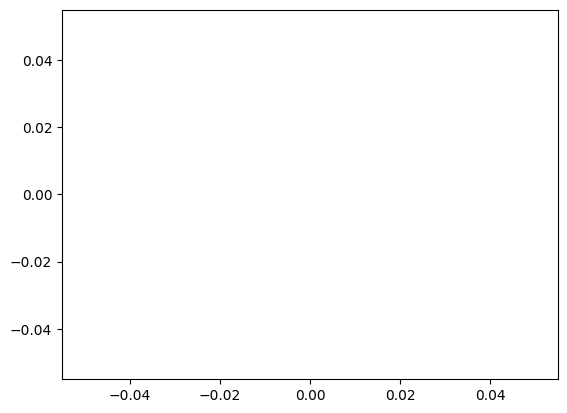

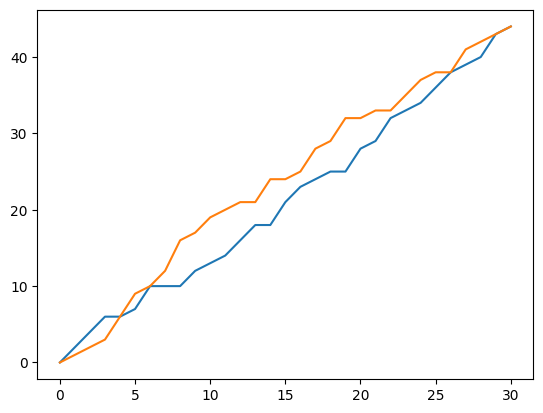

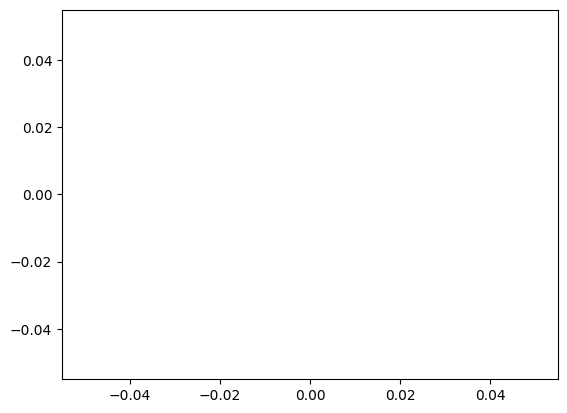

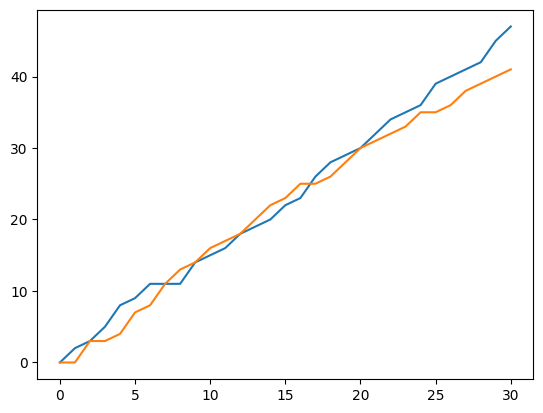

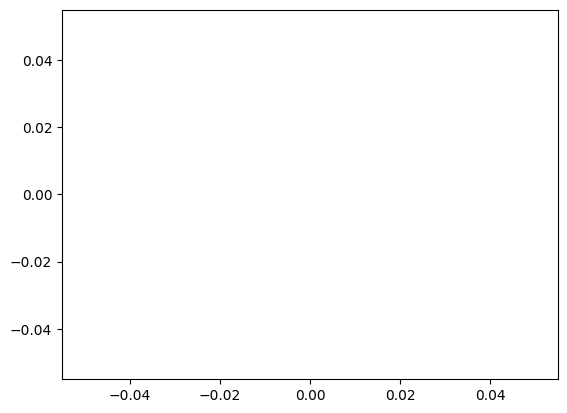

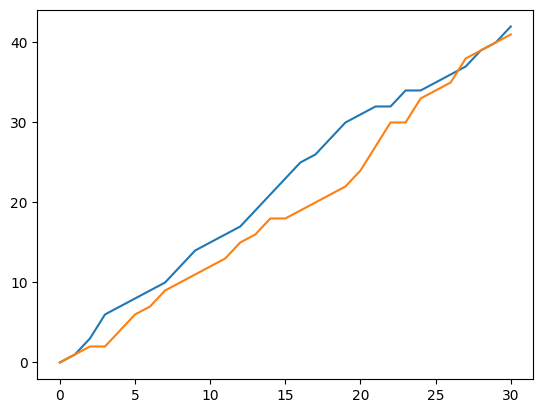

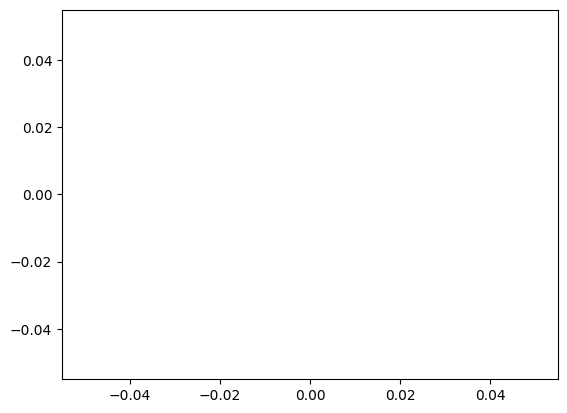

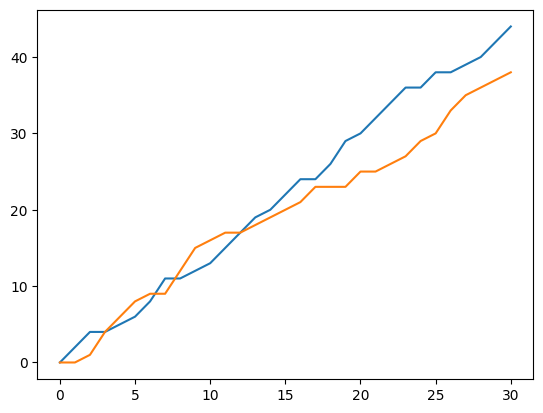

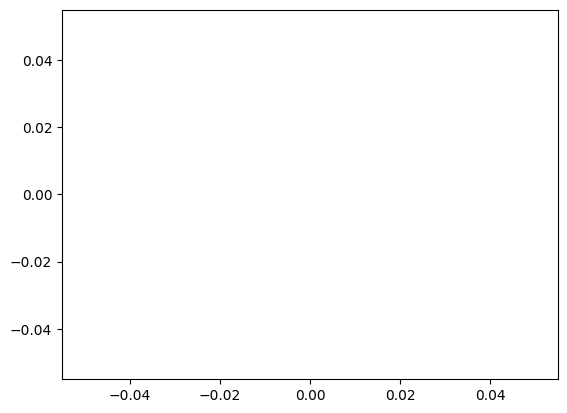

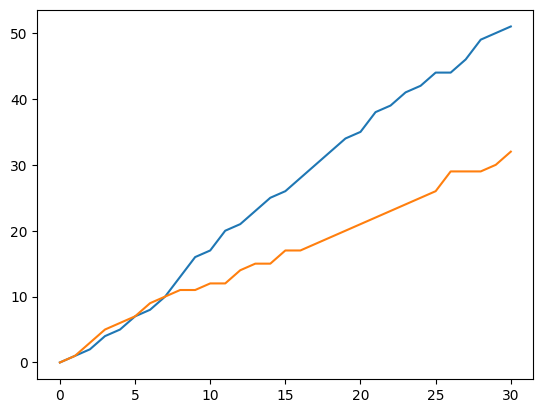

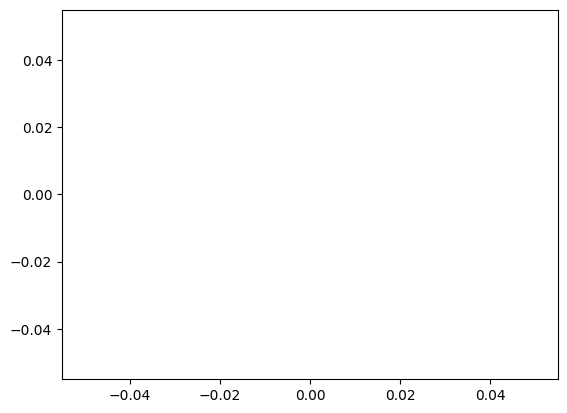

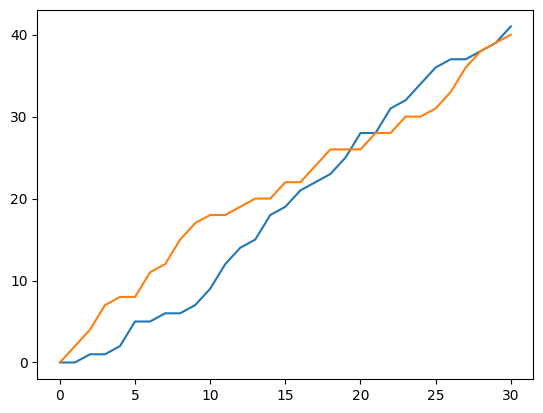

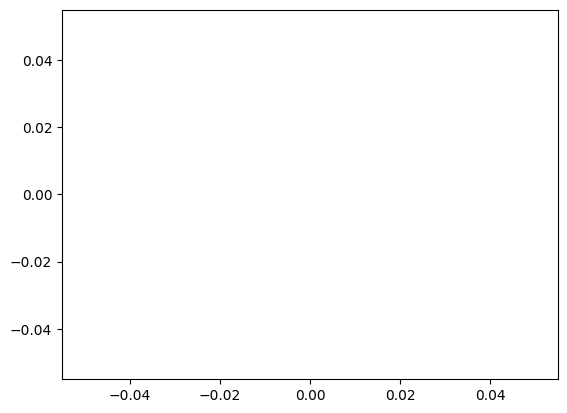

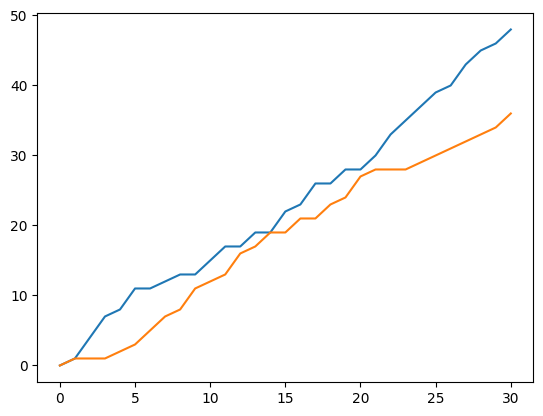

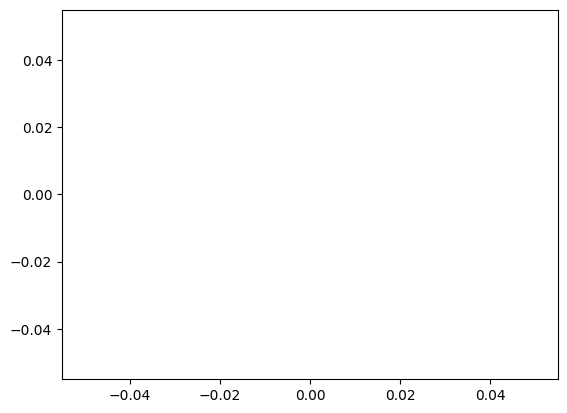

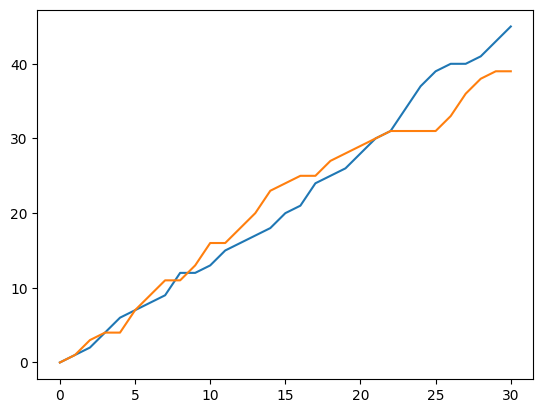

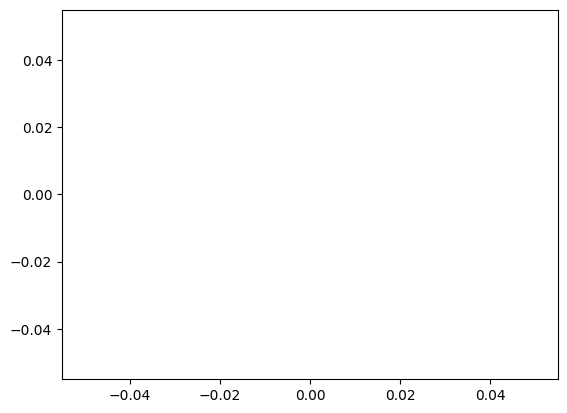

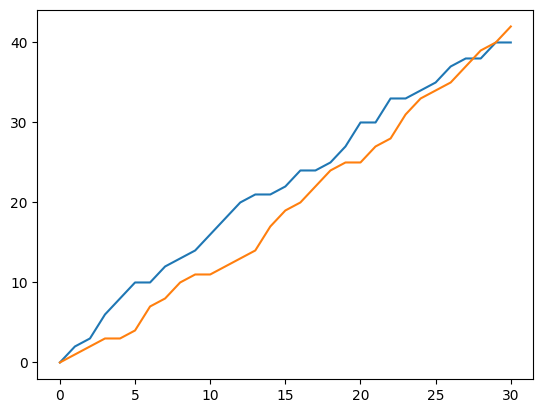

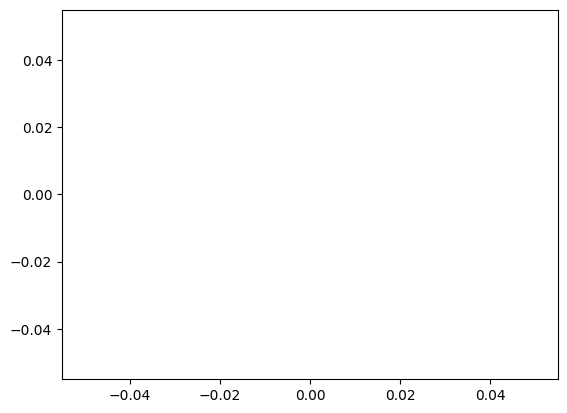

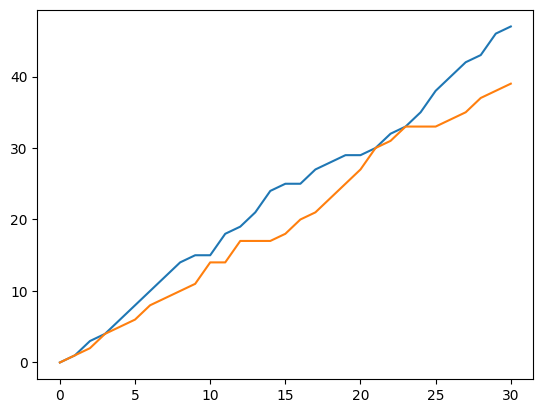

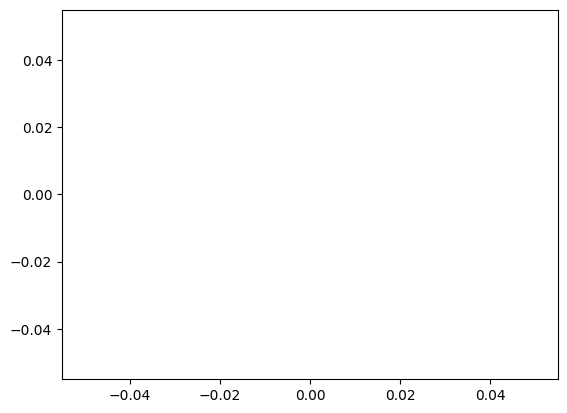

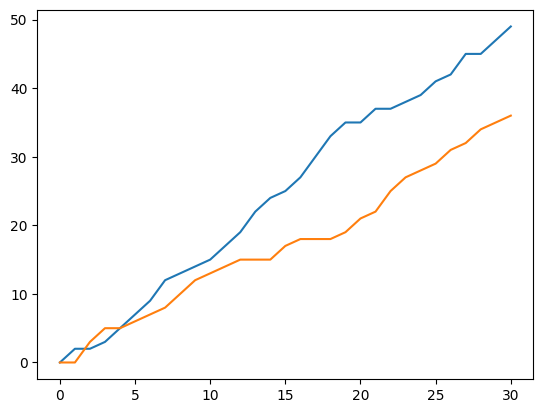

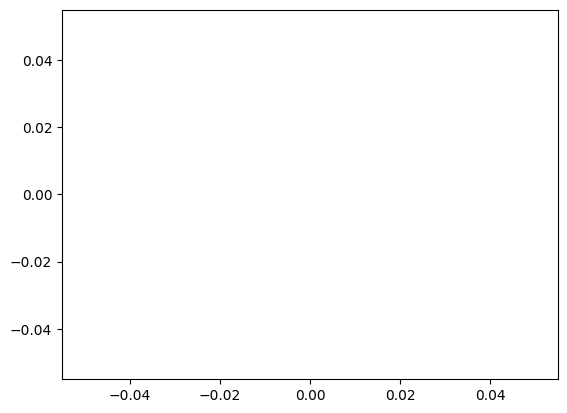

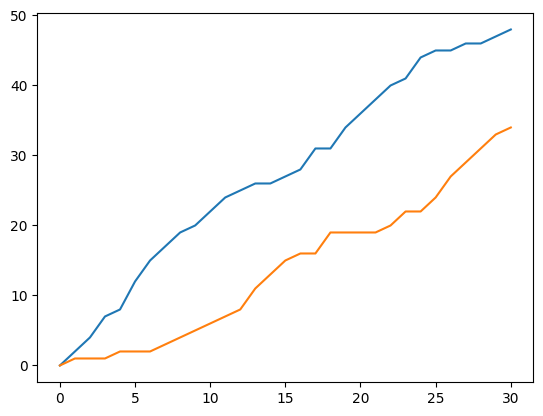

i: 1


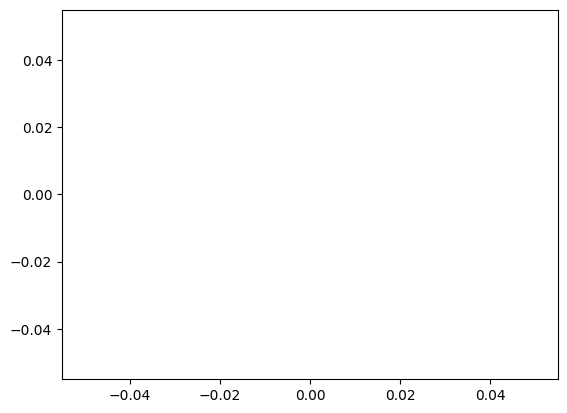

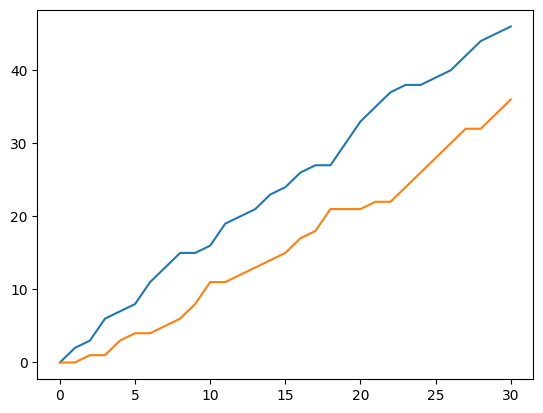

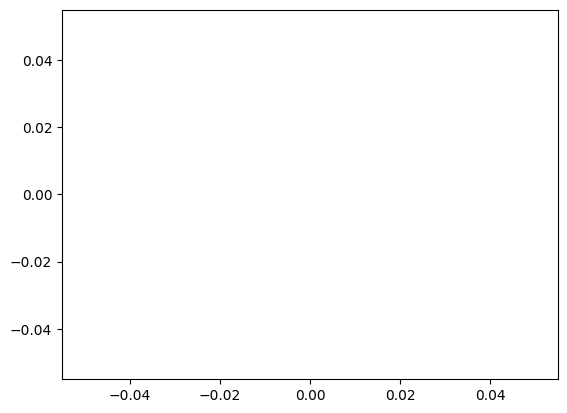

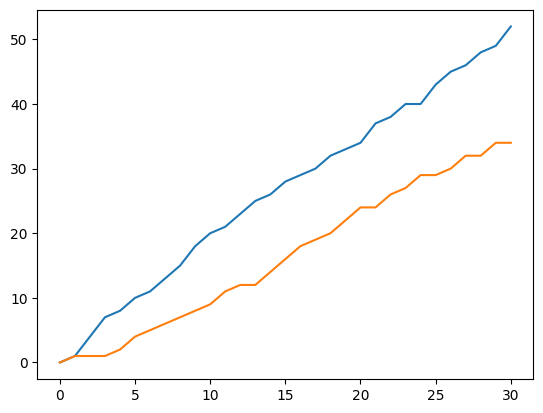

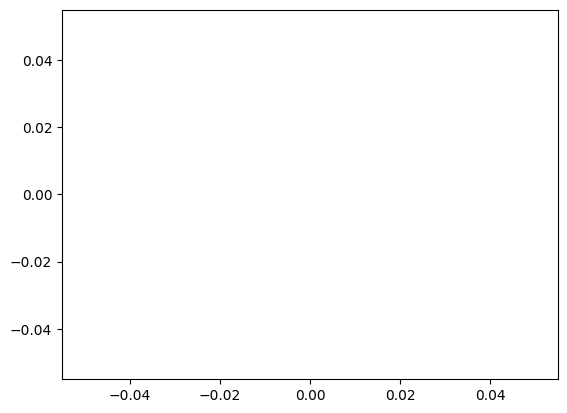

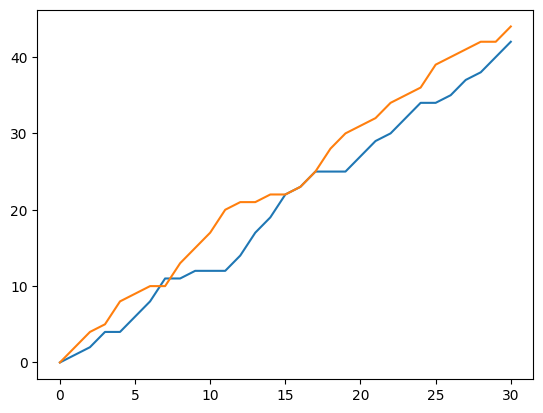

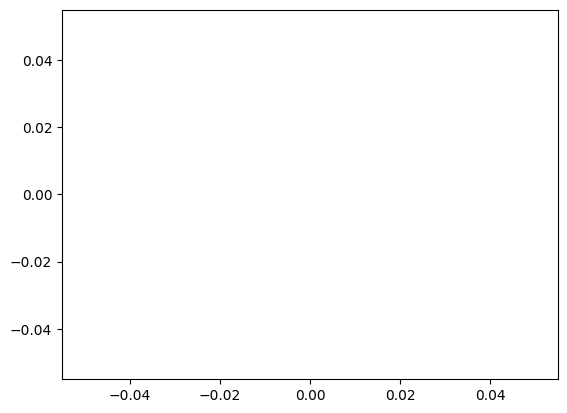

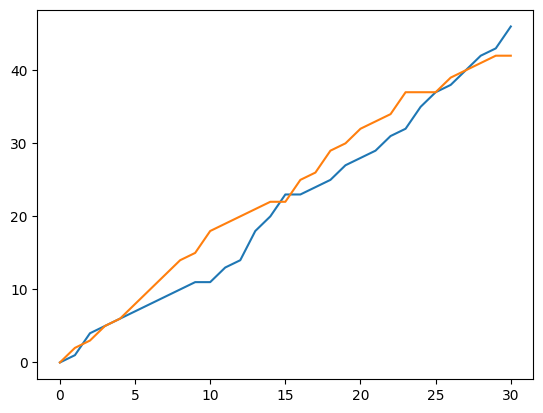

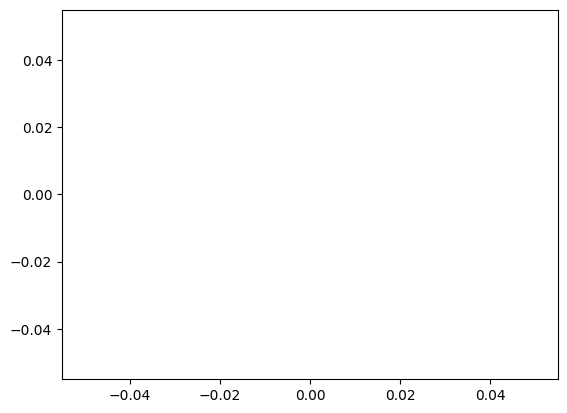

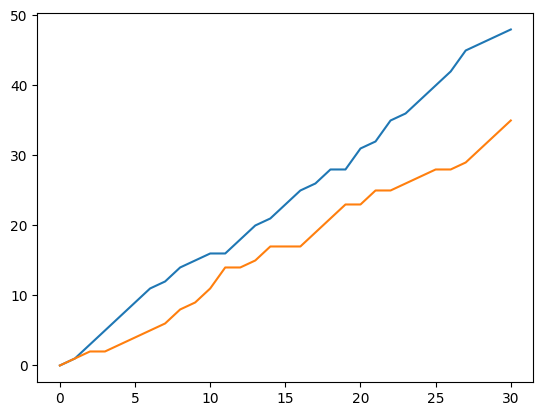

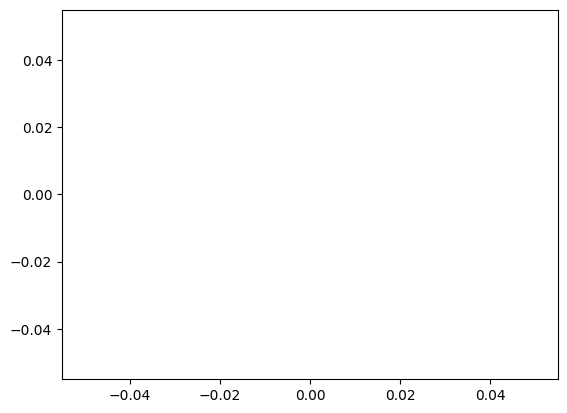

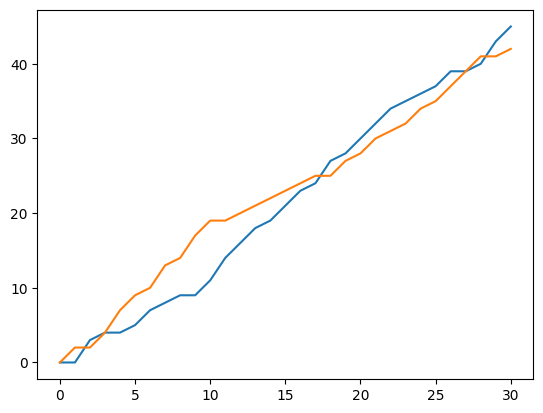

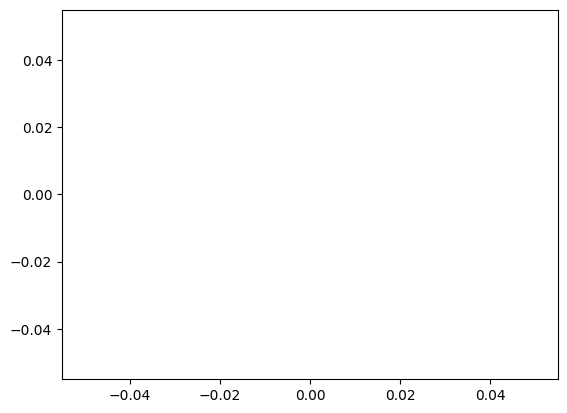

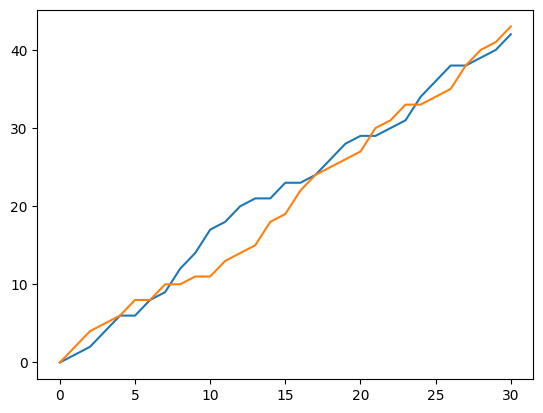

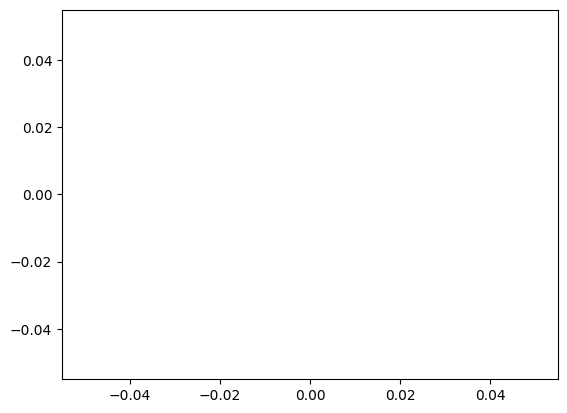

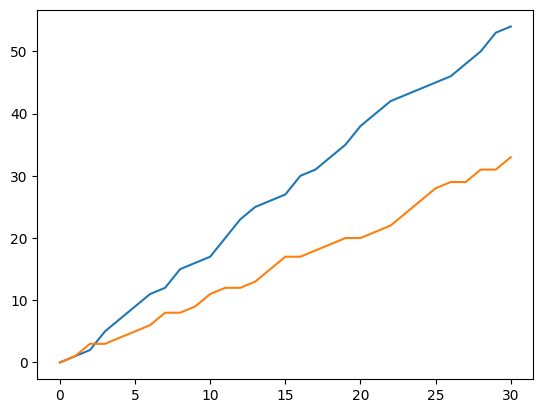

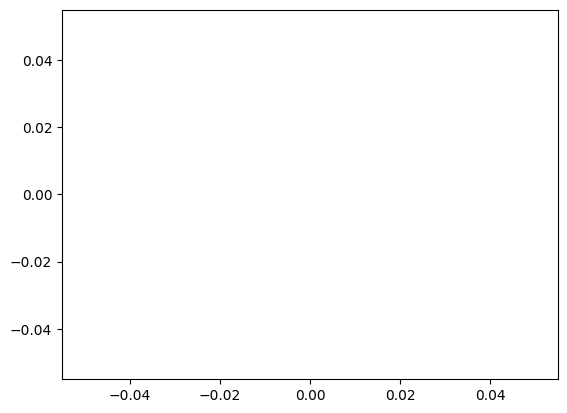

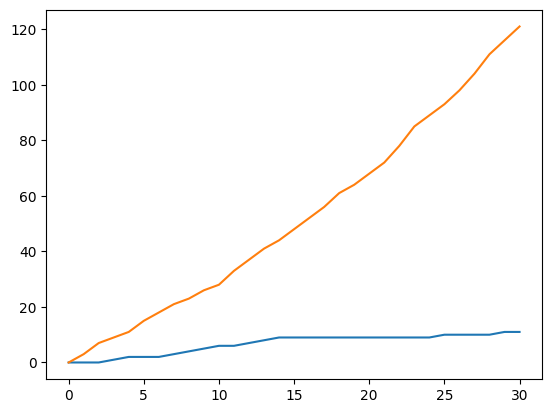

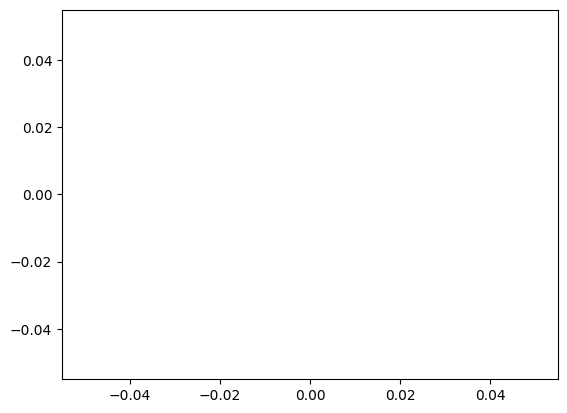

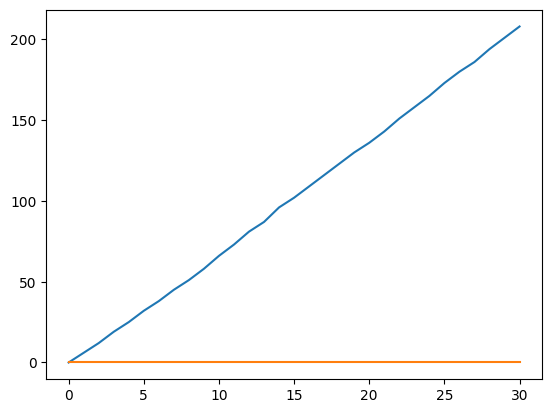

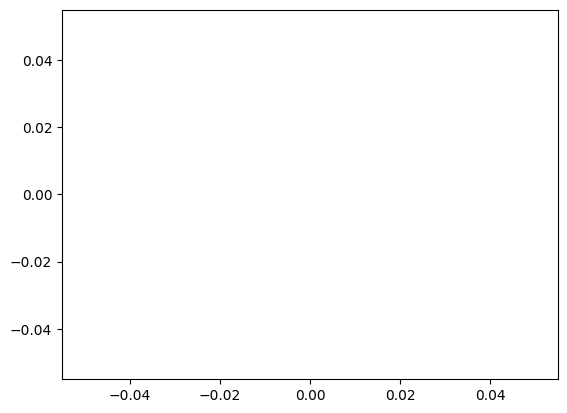

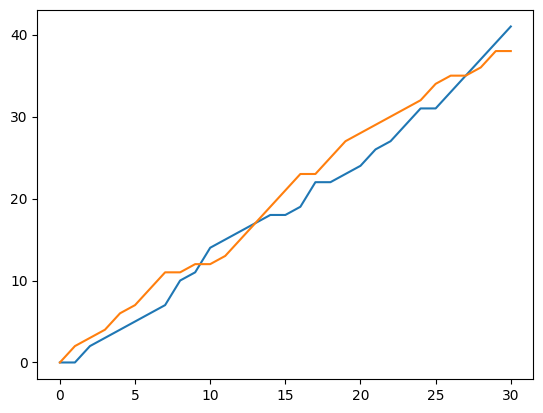

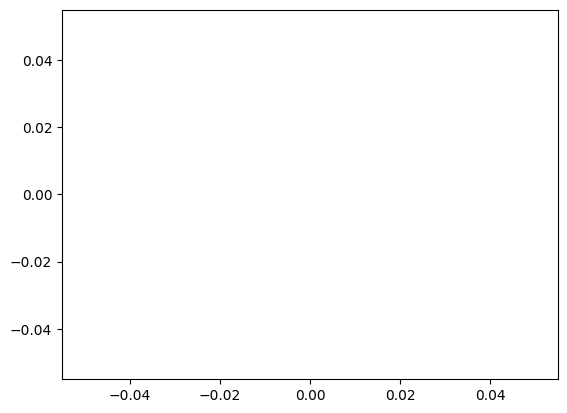

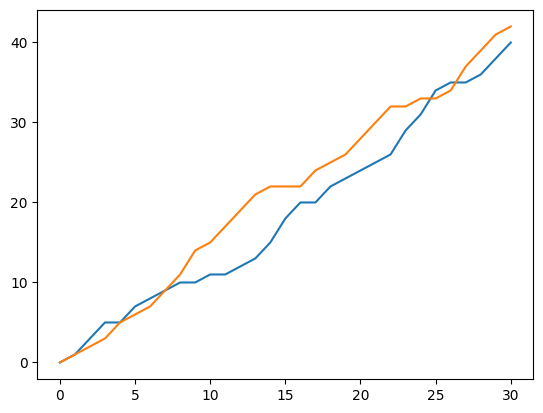

i: 2


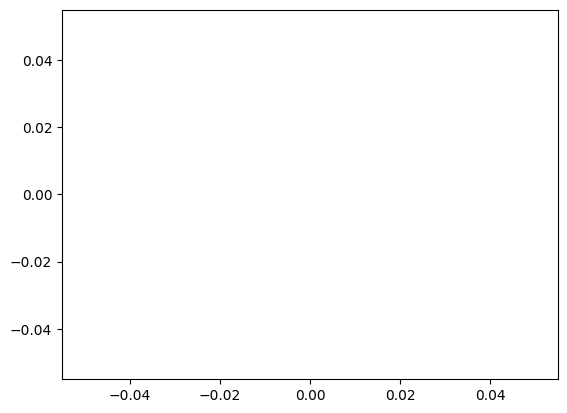

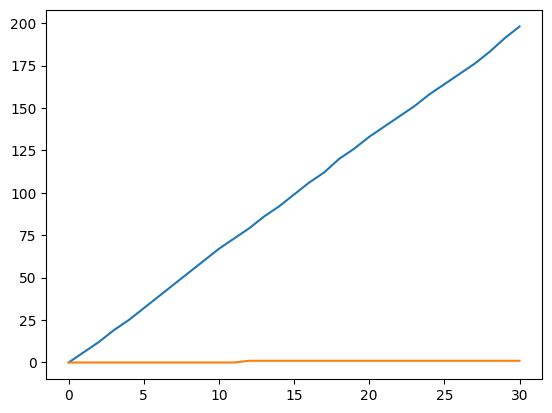

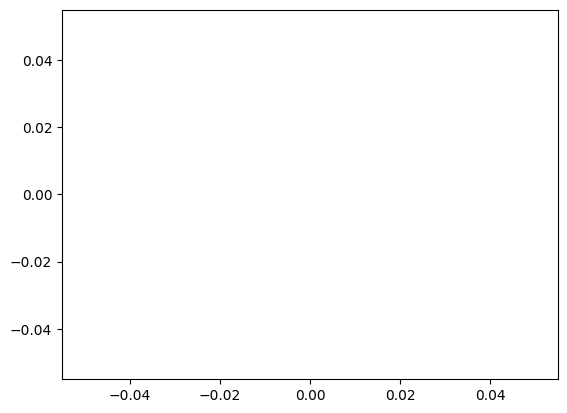

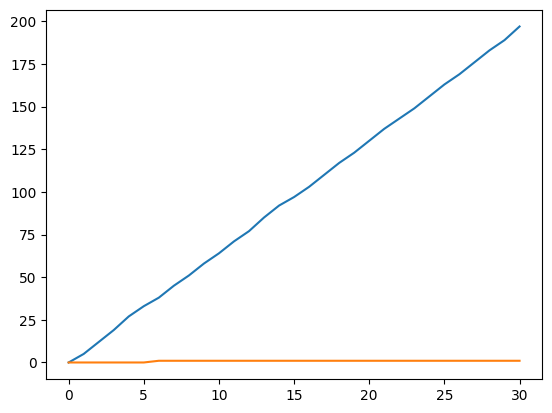

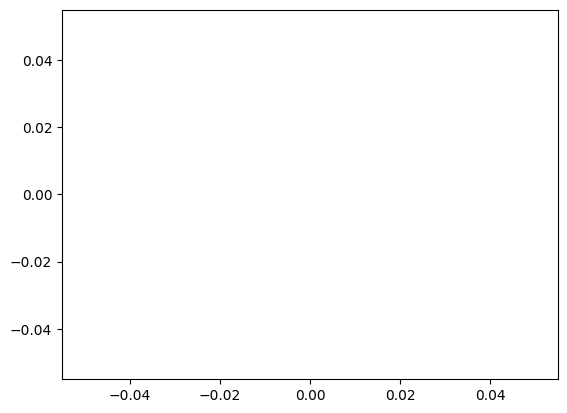

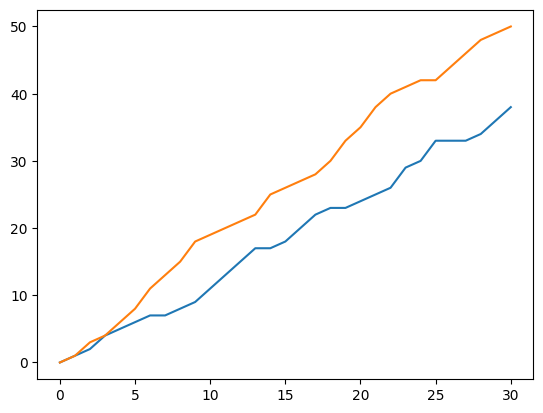

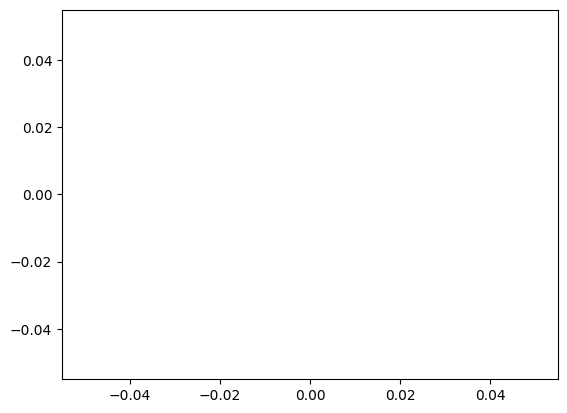

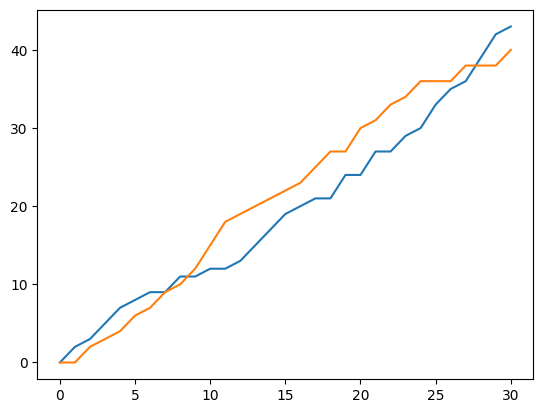

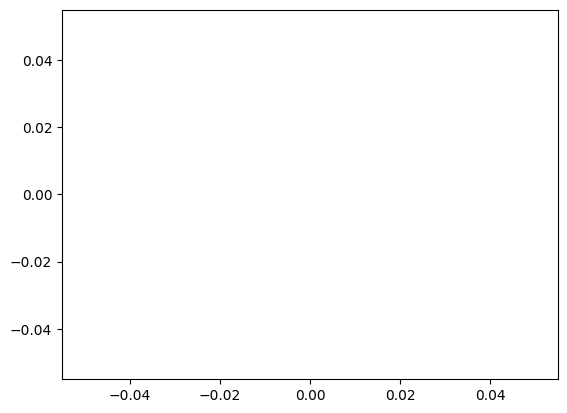

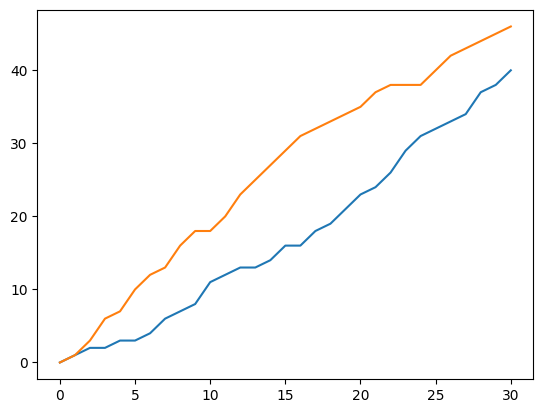

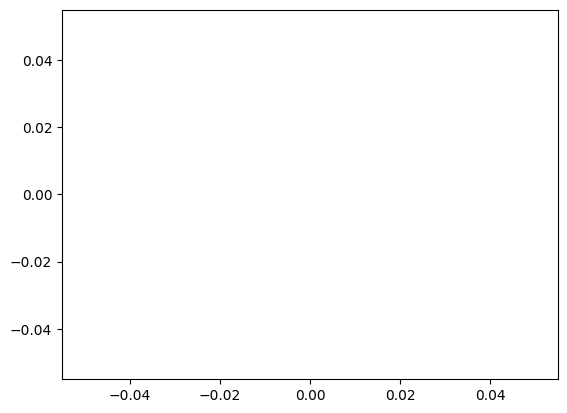

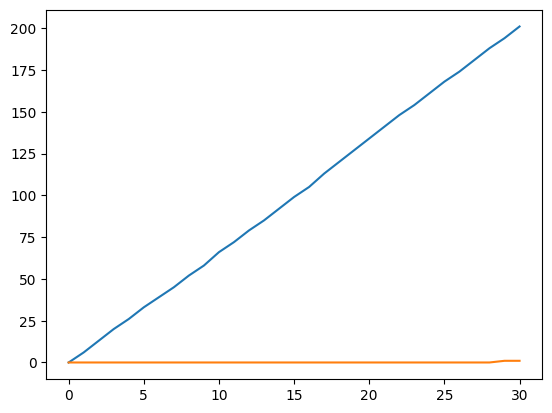

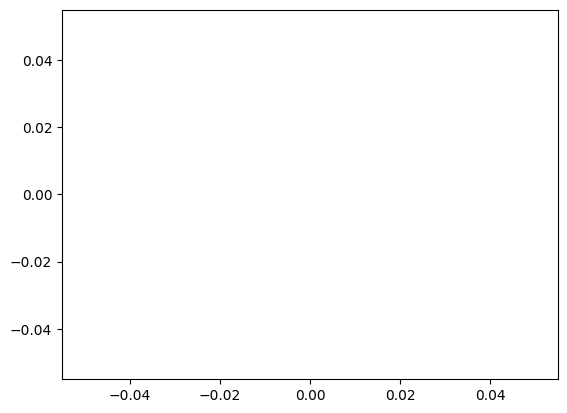

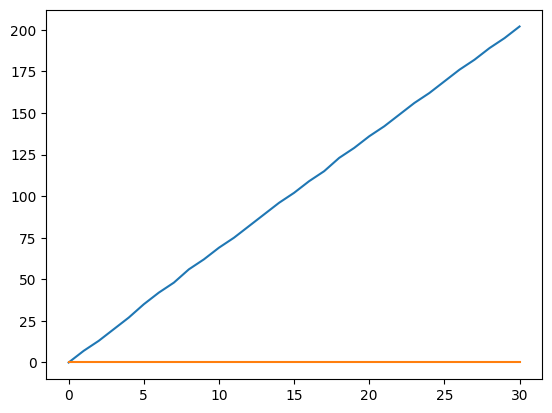

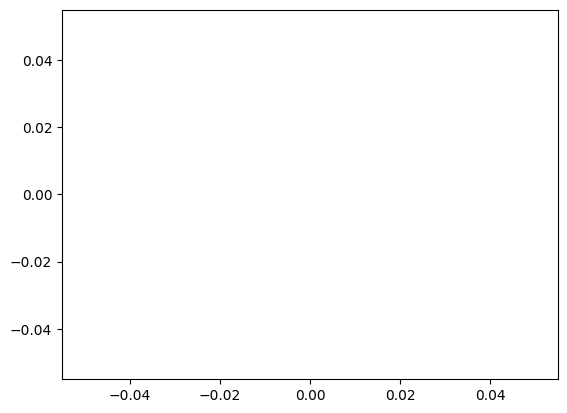

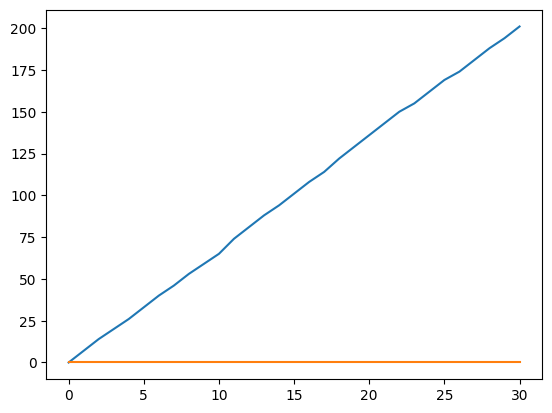

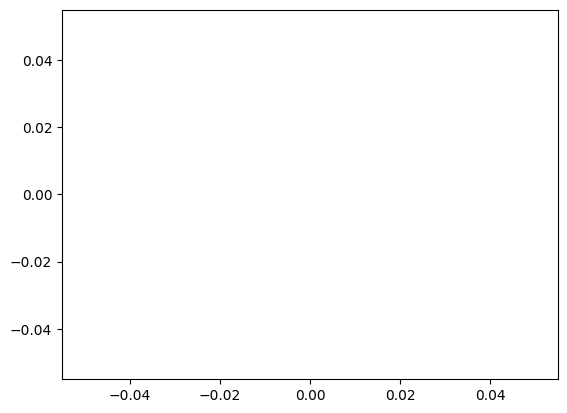

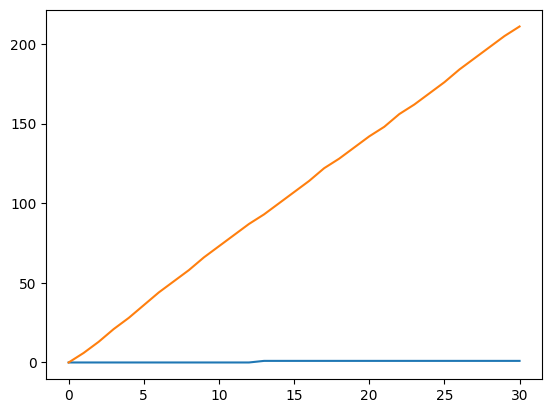

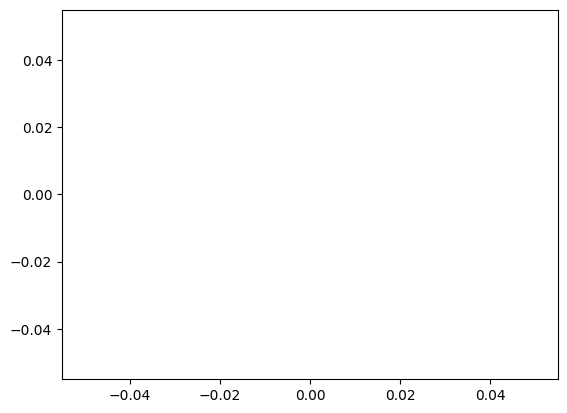

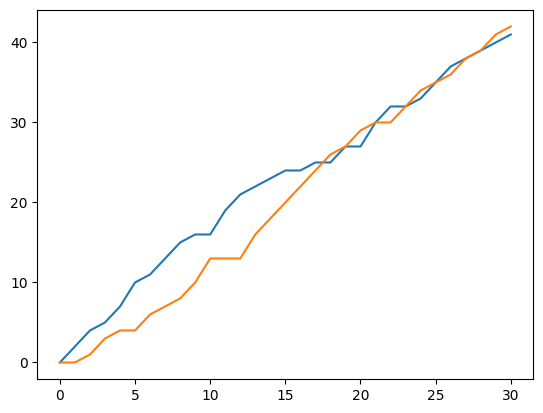

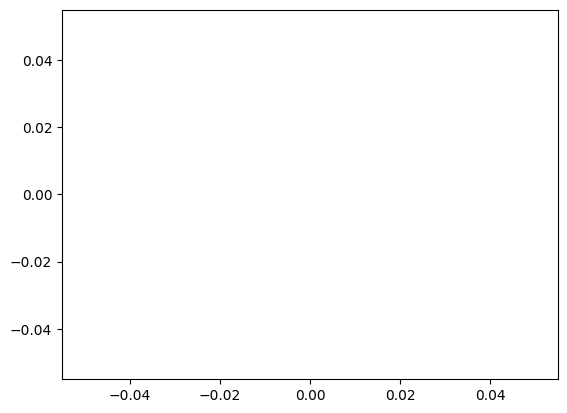

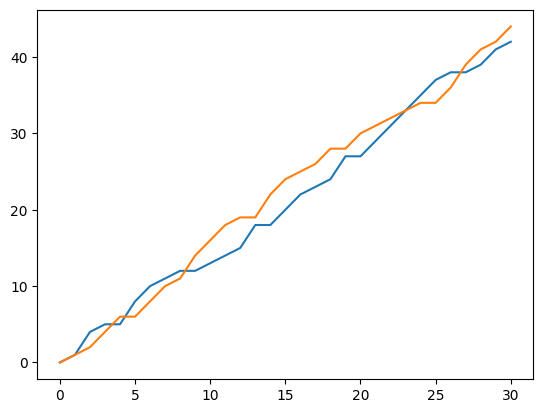

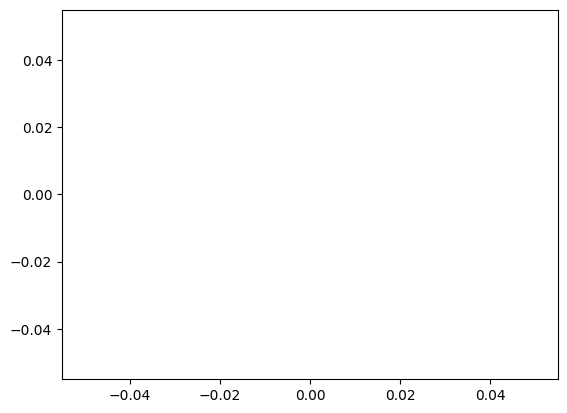

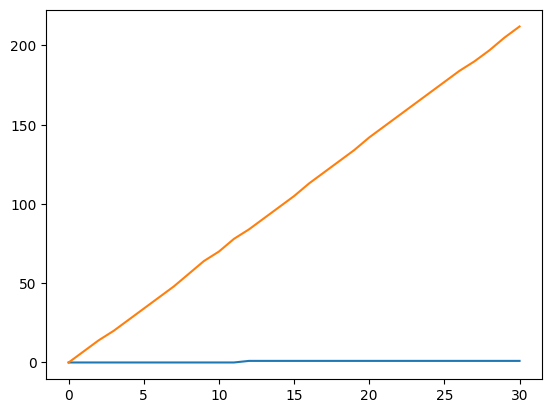

i: 3


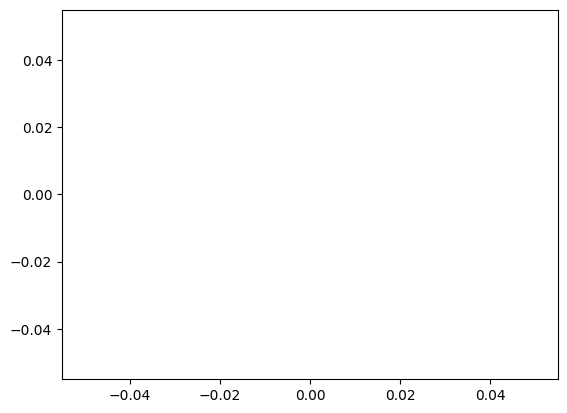

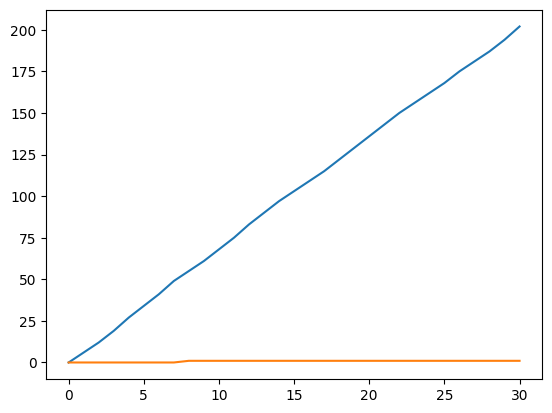

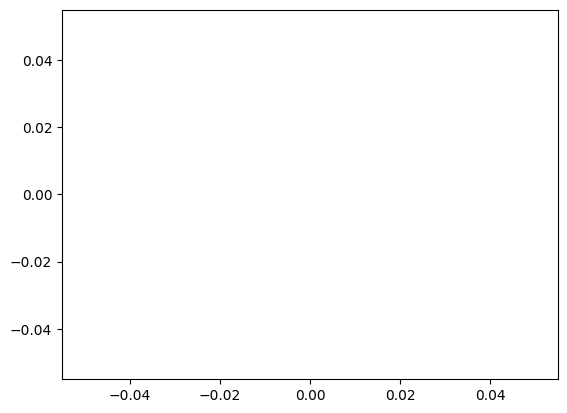

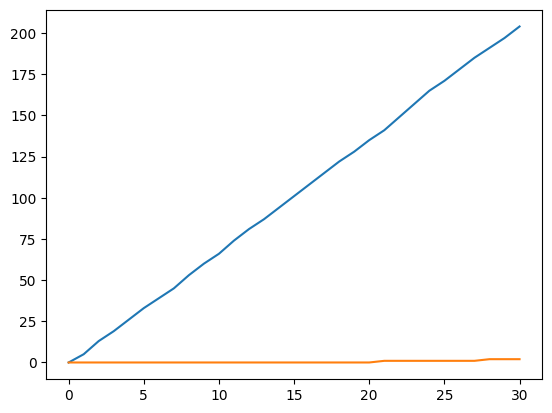

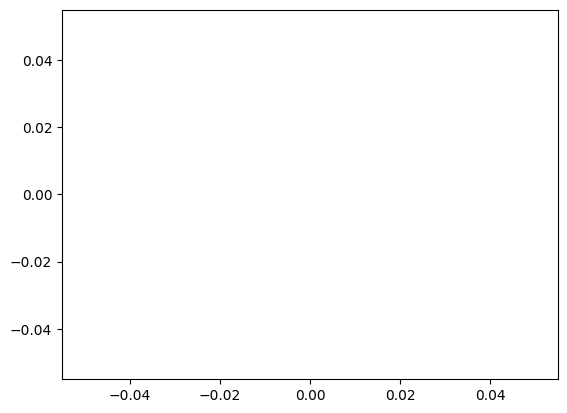

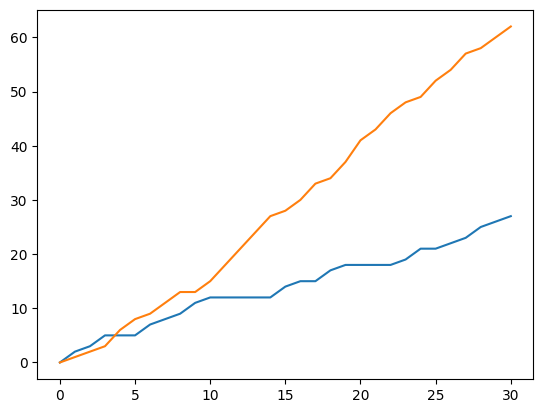

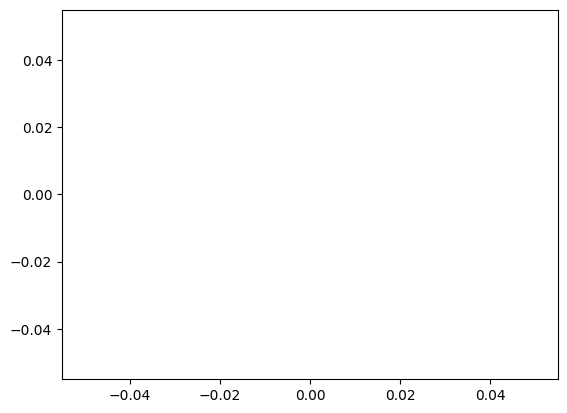

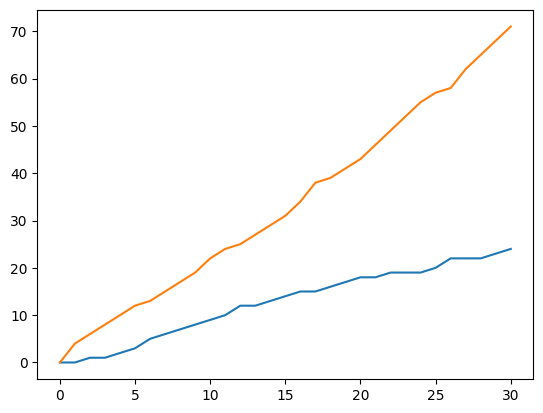

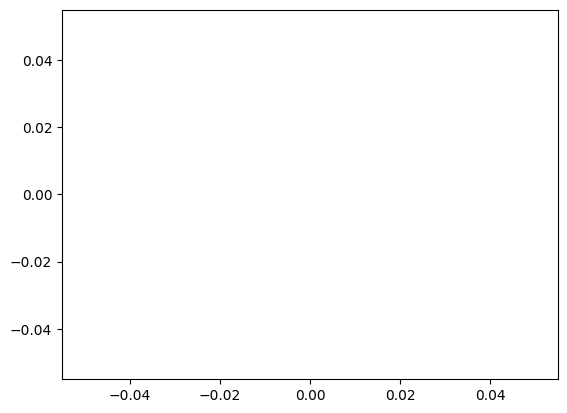

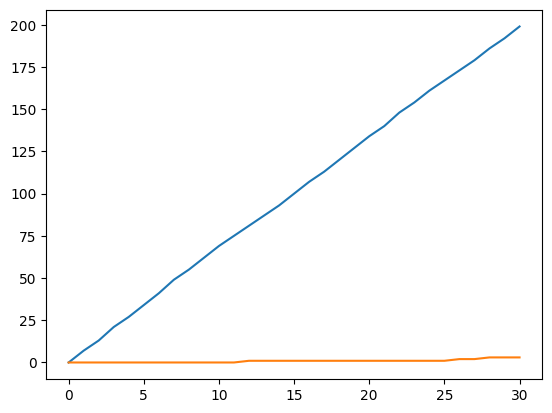

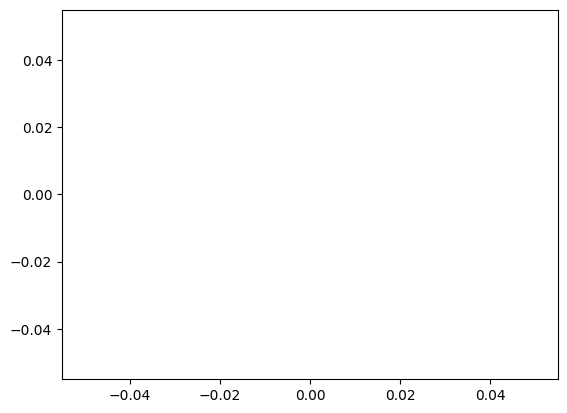

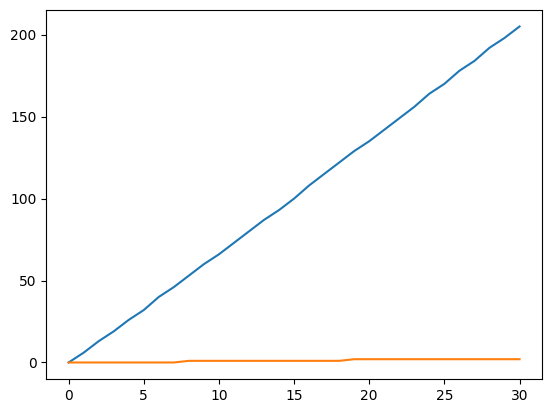

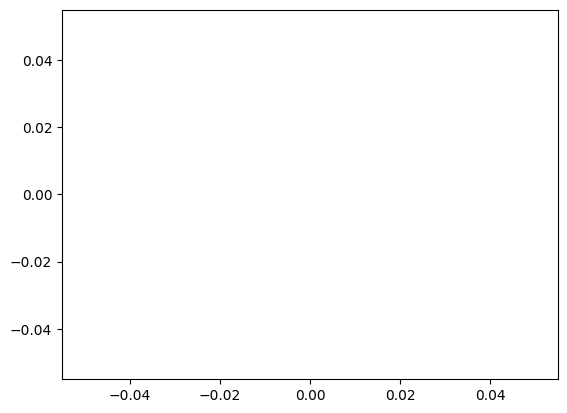

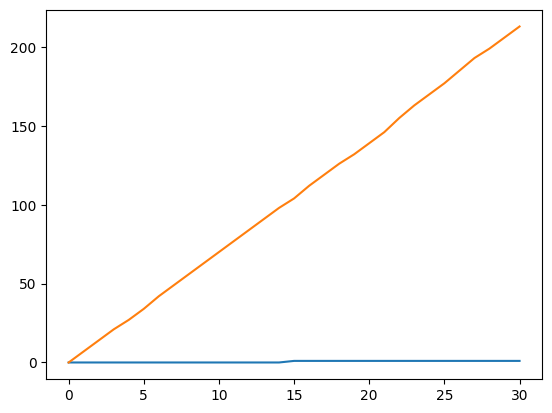

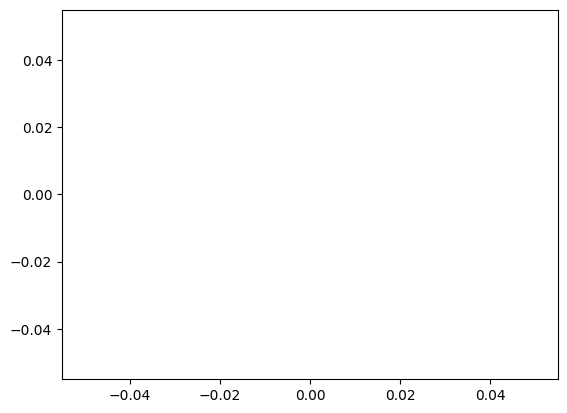

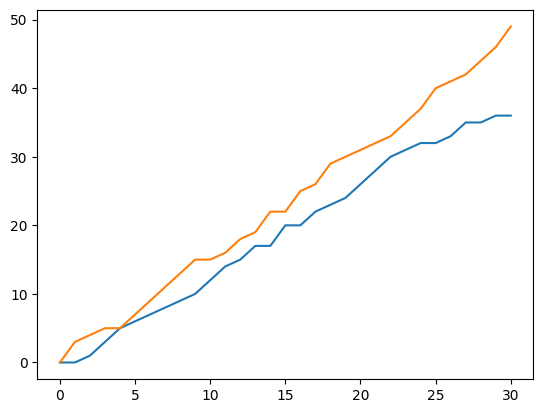

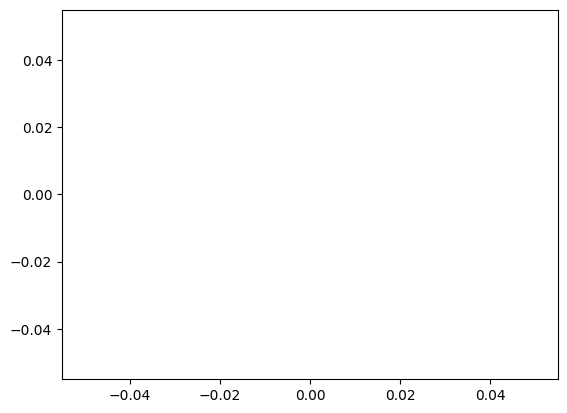

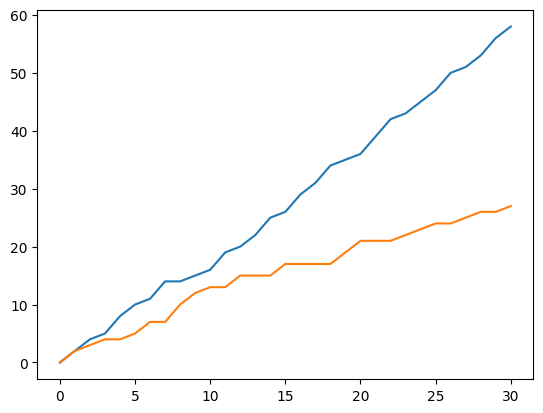

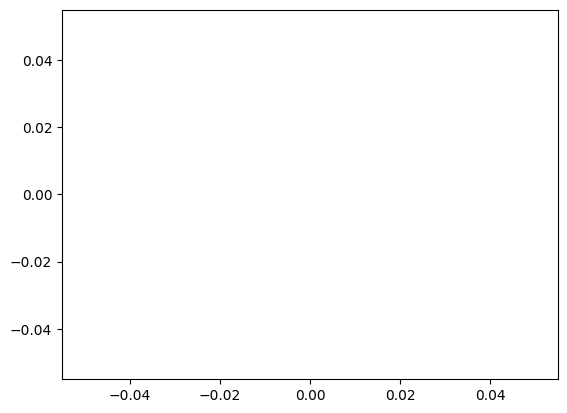

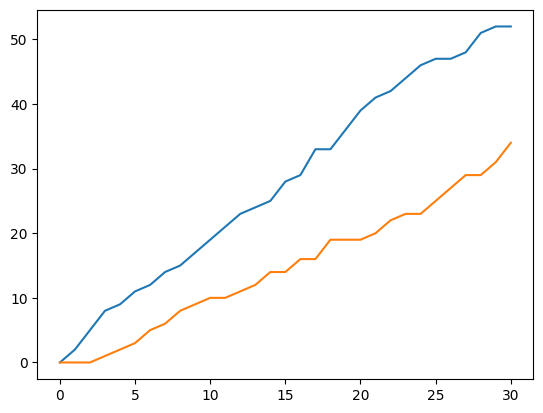

KeyboardInterrupt: 

In [131]:
for i in range(10):
  print('i:',i)
  black_white(0,model,optimizer,model,optimizer)
  black_white(0,model1,optimizer1,model1,optimizer1)
  black_white(0,model2,optimizer1,model2,optimizer2)
  black_white(0,model3,optimizer1,model3,optimizer3)

  help = [[model,optimizer],[model1,optimizer1],[model2,optimizer2],[model3,optimizer3]]

  for j in range(12):
    first = np.random.randint(4)
    while True:
      second = np.random.randint(4)
      if first != second:
        break
    black_white(5000,help[first][0],help[first][1],help[second][0],help[second][1])

  torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/model_state_dict.pt')
  torch.save(model1.state_dict(), '/content/drive/MyDrive/Colab Notebooks/model1_state_dict.pt')
  torch.save(model2.state_dict(), '/content/drive/MyDrive/Colab Notebooks/model2_state_dict.pt')
  torch.save(model3.state_dict(), '/content/drive/MyDrive/Colab Notebooks/model3_state_dict.pt')
  torch.save(optimizer.state_dict(), '/content/drive/MyDrive/Colab Notebooks/optimizer_state_dict.pt')
  torch.save(optimizer1.state_dict(), '/content/drive/MyDrive/Colab Notebooks/optimizer1_state_dict.pt')
  torch.save(optimizer2.state_dict(), '/content/drive/MyDrive/Colab Notebooks/optimizer2_state_dict.pt')
  torch.save(optimizer3.state_dict(), '/content/drive/MyDrive/Colab Notebooks/optimizer3_state_dict.pt')

In [125]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/model_state_dict.pt')
torch.save(model1.state_dict(), '/content/drive/MyDrive/Colab Notebooks/model1_state_dict.pt')
torch.save(model2.state_dict(), '/content/drive/MyDrive/Colab Notebooks/model2_state_dict.pt')
torch.save(model3.state_dict(), '/content/drive/MyDrive/Colab Notebooks/model3_state_dict.pt')
torch.save(optimizer.state_dict(), '/content/drive/MyDrive/Colab Notebooks/optimizer_state_dict.pt')
torch.save(optimizer1.state_dict(), '/content/drive/MyDrive/Colab Notebooks/optimizer1_state_dict.pt')
torch.save(optimizer2.state_dict(), '/content/drive/MyDrive/Colab Notebooks/optimizer2_state_dict.pt')
torch.save(optimizer3.state_dict(), '/content/drive/MyDrive/Colab Notebooks/optimizer3_state_dict.pt')

In [126]:
def every_pi(board, model = [model]):
  a = -1
  max = -10000
  batch = []
  where = []
  c = 0
  for i in range(11):
    for j in range(11):
      if board[i,j] == 0:
        batch += [board.copy().reshape(1,11,11)]
        batch[-1][0,i,j] = 1
        where += [[i,j]]
        c += 1

  if c == 0:
    return a

  batch = torch.tensor(np.array(batch), dtype=torch.float32).to(device)
  output = model[0](batch) + torch.normal(0, 0.1, size=(len(batch),1)).to(device)
  for i in range(1,len(model)):
    output += model[i](batch)
  output = output.reshape(-1)
  a = where[torch.argmax(output.reshape(-1))]

  return a

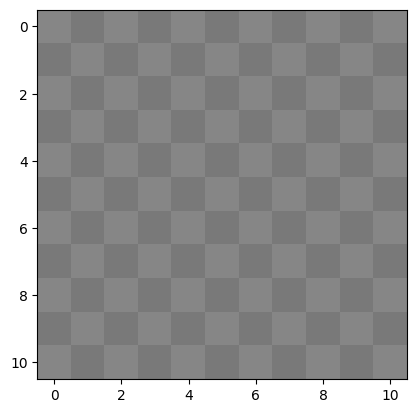

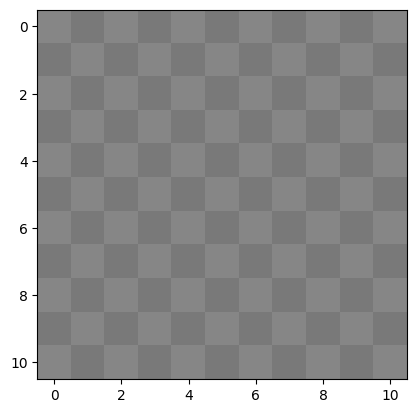

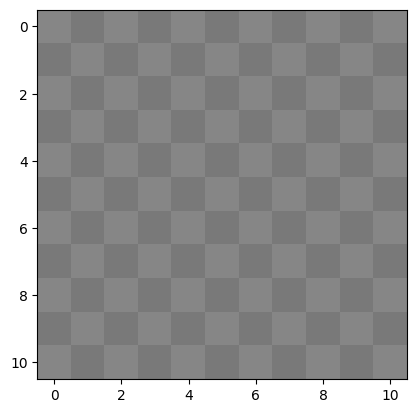

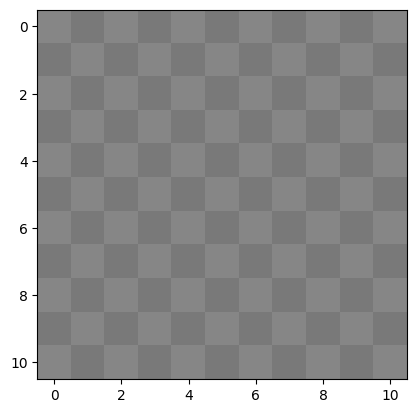

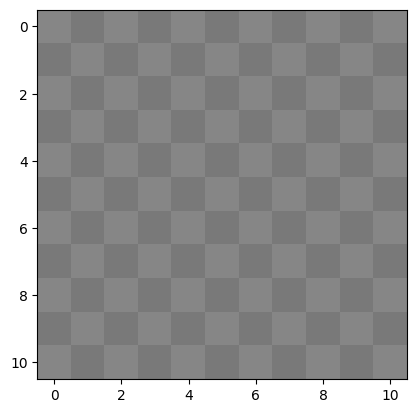

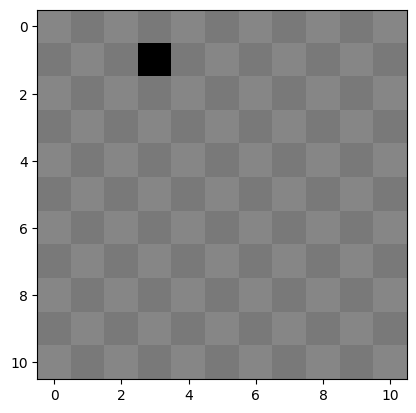

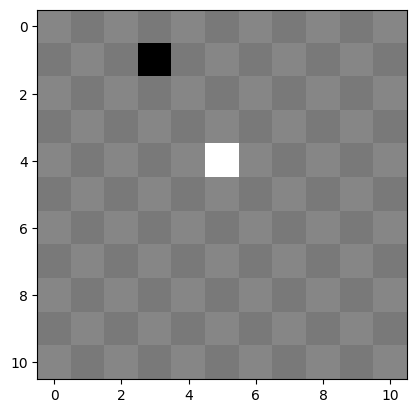

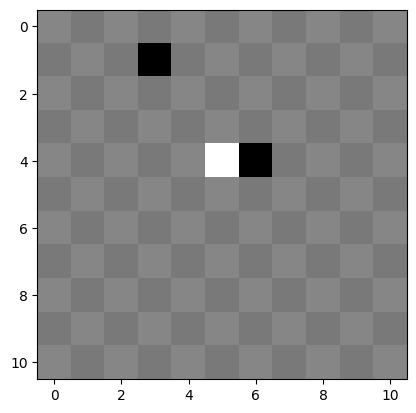

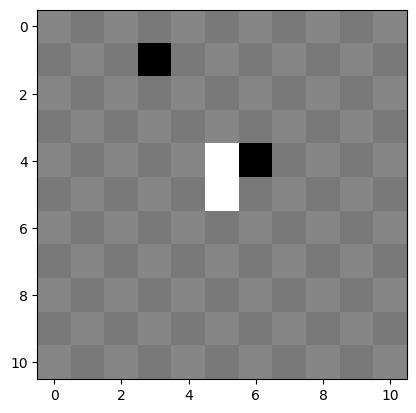

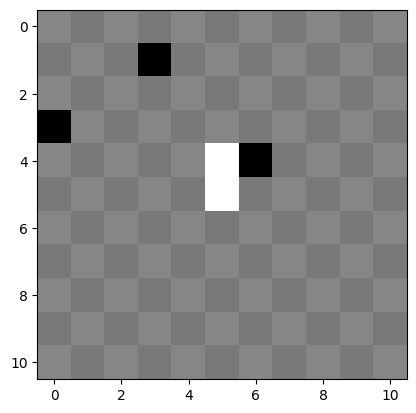

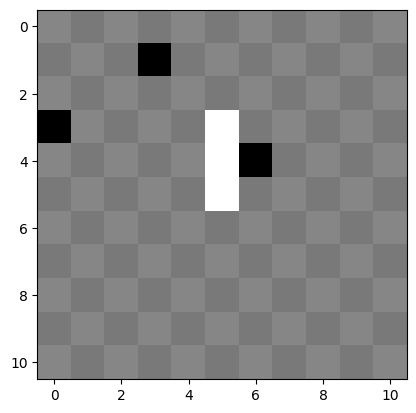

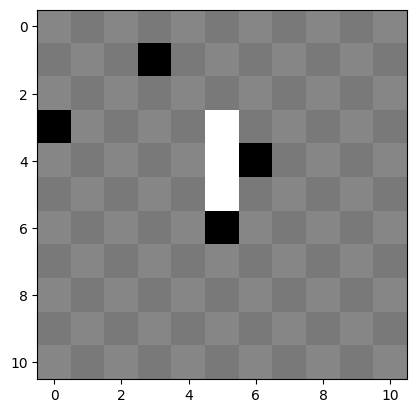

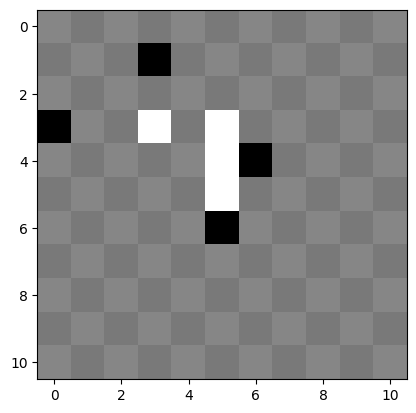

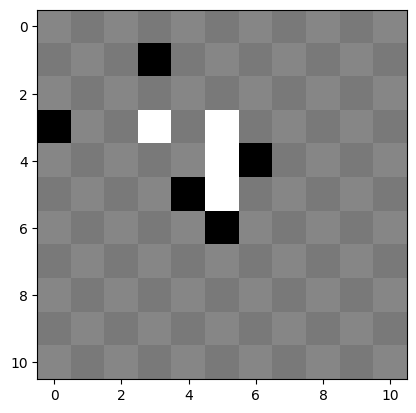

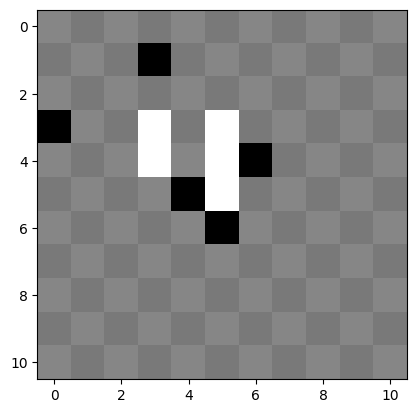

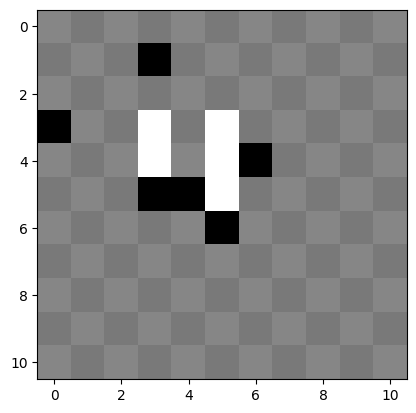

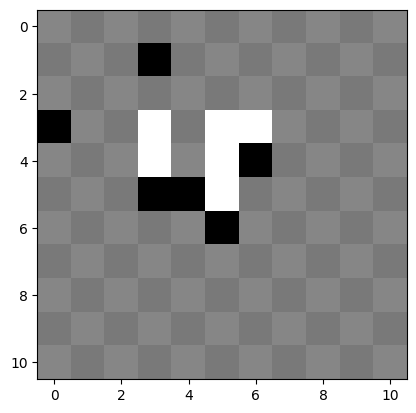

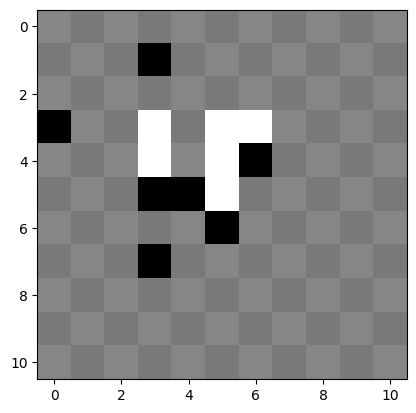

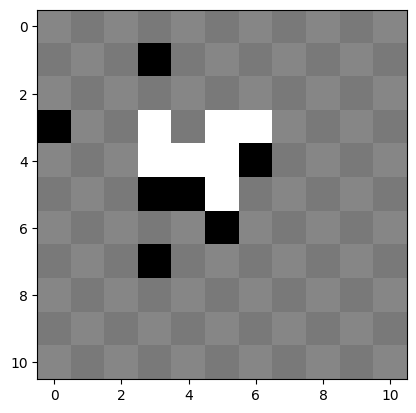

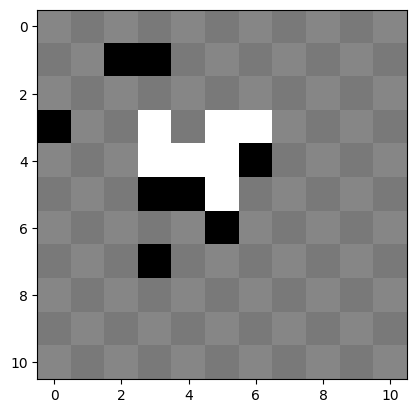

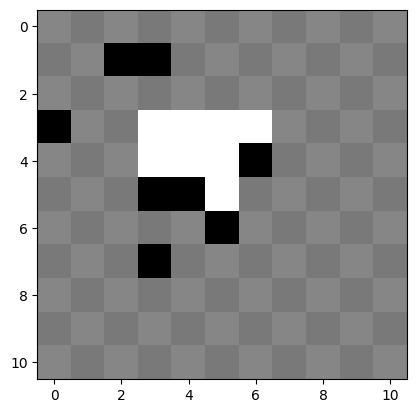

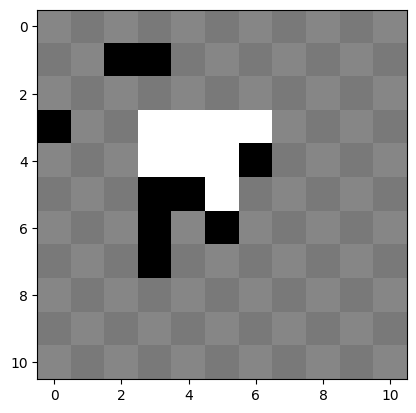

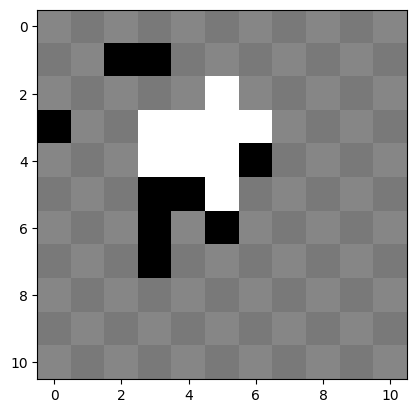

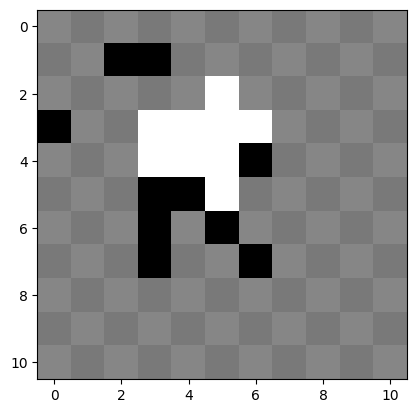

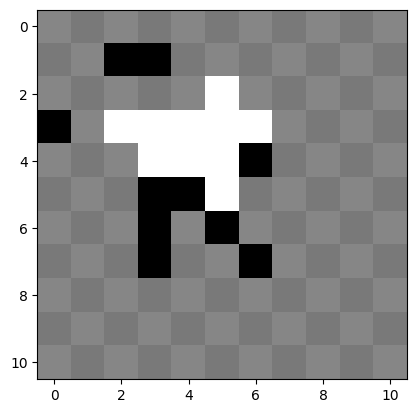

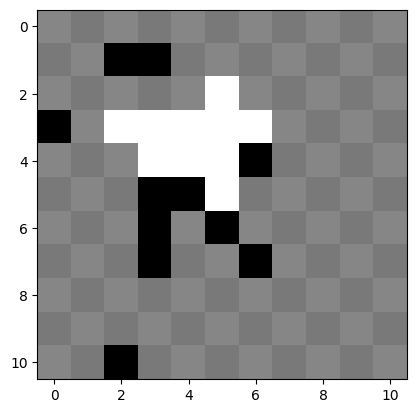

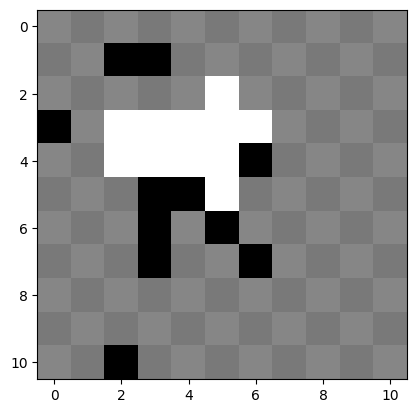

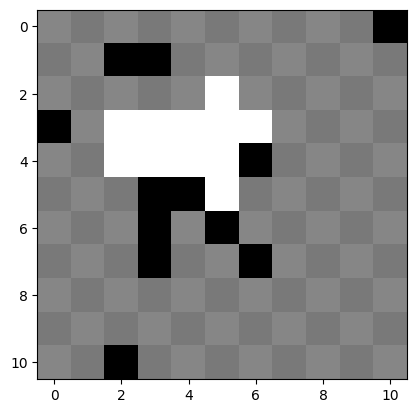

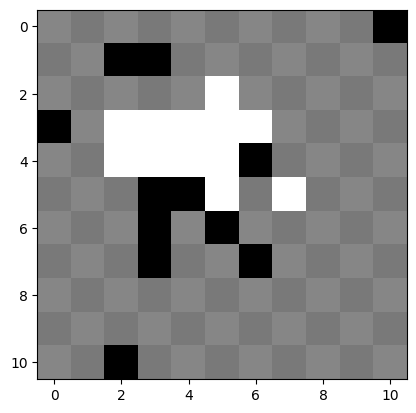

KeyboardInterrupt: 

In [138]:
import time

board = np.array([0.0]*11*11).reshape(11,11)
show_board(board)
show_board(board)
show_board(board)
show_board(board)
show_board(board)
time.sleep(3)
while True:
  a = every_pi(board,[model])
  board[tuple(a)] = 1
  show_board(board)
  time.sleep(0.5)

  a = every_pi(board*-1,[model1])
  board[tuple(a)] = -1
  show_board(board)
  time.sleep(0.5)